# Visualizing BERT embeddings from Wikipedia, EURLEX and Privacy Policies using t-SNE and UMAP

In this notebook, we probe the BERT sequence embeddings of texts from the general, legal and privacy domains. These documents come from Wikipedia, EURLEX and privacy policies respectively. We go about this by first computing BERT embeddings and then compute t-SNE and UMAP dimensionality reduction for plotting.

First we download data from Wikipedia, EURLEX and Privacy Policies. After that, we load this data into memory.

In [169]:
import os
import random

import matplotlib
import pandas as pd
import requests
import torch
import umap
from datasets import load_dataset
from plotnine import (
    aes,
    element_blank,
    element_rect,
    element_text,
    geom_point,
    ggplot,
    guide_legend,
    guides,
    scale_color_manual,
    theme,
    theme_bw,
)
from sklearn.manifold import TSNE
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

%matplotlib inline
matplotlib.rc("text", usetex=True)

In [155]:
# download and load datasets
eurlex = load_dataset("eurlex")
wikipedia = load_dataset("wikipedia", "20220301.en")

# download privacy policies if they are not present
privacy_file = os.path.join("data", "policies.jsonl")
if not os.path.exists(privacy_file):
    privacy = requests.get(
        "https://drive.switch.ch/index.php/s/pA71WgN8zf2ALbW/download"
    )
    with open(privacy_file, "wb") as output_file_stream:
        output_file_stream.write(privacy.content)

# load privacy file as dataset
privacy = load_dataset("json", data_files=privacy_file)

No config specified, defaulting to: eurlex/eurlex57k
Reusing dataset eurlex (/home/shankar/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset wikipedia (/home/shankar/.cache/huggingface/datasets/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-7c3a3e54152170eb
Reusing dataset json (/home/shankar/.cache/huggingface/datasets/json/default-7c3a3e54152170eb/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253)


  0%|          | 0/1 [00:00<?, ?it/s]

Then we load the `BERT` model and its tokenizer:

In [156]:
# load model and tokenizer and send model to the GPU (assuming we have one)
model = AutoModel.from_pretrained("bert-base-uncased").to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Then we compute the corpus embeddings given a token upper limit of 2,500,000 tokens in each corpus.

In [157]:
def get_corpus_embeddings(corpus, text_column="text", limit=2500000, seed=42):
    # initialize variables and shuffle corpus
    corpus_embeddings = []
    indices = list(range(len(corpus)))
    random.seed(seed)
    random.shuffle(indices)
    count = 0

    # loop over corpus text column
    with tqdm(indices, desc="Embed and count tokens") as tqdm_iterator:
        for index in tqdm_iterator:
            # tokenize input
            input_ids = tokenizer.encode(
                corpus[index][text_column], truncation=True, return_tensors="pt"
            ).to("cuda:0")

            # add tokens to global counter
            # NOTE: we minus 2 to account for the [CLS] and [SEP] tokens
            count += input_ids.shape[1] - 2

            # update tqdm display
            tqdm_iterator.set_postfix_str("tokens: %s/%s" % (count, limit))

            # check if count satisfies limit
            if count >= limit:
                break
            else:
                outputs = model(input_ids)
                cls_embedding = outputs.last_hidden_state.detach()[:, 0, :].cpu()
                corpus_embeddings.append(cls_embedding)
        else:
            raise ValueError("Unable to satisfy %s token limit" % limit)

    # concatenate list into single tensor
    return torch.cat(corpus_embeddings), indices[: indices.index(index)]

We compile everything together and compute t-SNE/UMAP embeddings.

In [158]:
# compute corpus embeddings
wikipedia_embeddings, wikipedia_indices = get_corpus_embeddings(wikipedia["train"])
eurlex_embeddings, eurlex_indices = get_corpus_embeddings(eurlex["train"])
privacy_embeddings, privacy_indices = get_corpus_embeddings(privacy["train"])

Embed and count tokens:  98%|██████▊| 4903/5000 [01:47<00:02, 45.63it/s, tokens: 2500126/2500000]


In [159]:
# compute lengths of each corpus
wikipedia_length = wikipedia_embeddings.shape[0]
eurlex_length = eurlex_embeddings.shape[0]
privacy_length = privacy_embeddings.shape[0]

Now we find some interesting examples that we can plot later.

In [241]:
wikipedia["train"].select(wikipedia_indices)[300]

{'id': '25149718',
 'url': 'https://en.wikipedia.org/wiki/Cipher%20suite',
 'title': 'Cipher suite',
 'text': "A cipher suite is a set of algorithms that help secure a network connection. Suites typically use Transport Layer Security (TLS) or its now-deprecated predecessor Secure Socket Layer (SSL). The set of algorithms that cipher suites usually contain include: a key exchange algorithm, a bulk encryption algorithm, and a message authentication code (MAC) algorithm.\n\nThe key exchange algorithm is used to exchange a key between two devices. This key is used to encrypt and decrypt the messages being sent between two machines. The bulk encryption algorithm is used to encrypt the data being sent. The MAC algorithm provides data integrity checks to ensure that the data sent does not change in transit. In addition, cipher suites can include signatures and an authentication algorithm to help authenticate the server and or client.\n\nOverall, there are hundreds of different cipher suites t

In [228]:
eurlex["train"].select(eurlex_indices)[3]

{'celex_id': '31997D0090',
 'title': 'Commission Decision of 24 January 1997 extending the period referred to in Article 15 (2a) of Directive 66/403/EEC on the marketing of seed potatoes\n',
 'text': "COMMISSION DECISION of 24 January 1997 extending the period referred to in Article 15 (2a) of Directive 66/403/EEC on the marketing of seed potatoes (97/90/EC)\nTHE COMMISSION OF THE EUROPEAN COMMUNITIES\n,\nHaving regard to the Treaty establishing the European Community,\nHaving regard to Council Directive 66/403/EEC of 14 June 1966 on the marketing of seed potatoes (1), as last amended by Directive 96/72/EC (2), and in particular Article 15 (2a) thereof,\nWhereas in principle, with effect from certain dates, Member States may no longer determine for themselves the equivalence of seed potatoes harvested in third countries with seed potatoes harvested within the Community and complying with that Directive;\nWhereas, however, since work to establish Community equivalence for all the third 

In [236]:
privacy["train"].select(privacy_indices)[4]

{'text': 'OUR PRIVACY POLICY\n\nEffective: May 25, 2018\n\nLast Updated : July 19, 2019\n\nThis privacy policy (" Privacy Policy") describes how information and data is collected from you when you use this online website, mobile website, application, digital service, or any related products, services, sites, features or functionality (each a " Service", collectively the " Services") and how Leaf Group Ltd., including its subsidiaries/affiliates Society 6, LLC, Saatchi Online, Inc., and Well+Good, LLC (" Leaf Group", " we", " us", or " our"), uses, shares and manages your information and data. By using any of the Services, you consent to the collection, use, processing, and sharing of your information as described in this Privacy Policy.\n\n1\\. Our Privacy Principles\n\nWe are committed to recognizing and respecting your privacy rights by keeping you informed and processing and protecting your personal data in compliance with applicable data protection laws and regulations ( "Data Prot

In [242]:
# compute indices of interesting samples
interesting_wikipedia = 300
interesting_eurlex = wikipedia_length + 3
interesting_privacy = wikipedia_length + eurlex_length + 4

We resume plotting embeddings.

In [160]:
# concatenate everything into single tensor and domains
all_embeddings = torch.cat(
    [wikipedia_embeddings, eurlex_embeddings, privacy_embeddings]
)
domains = (
    ["Wikipedia"] * wikipedia_length
    + ["EURLEX"] * eurlex_length
    + ["Privacy"] * privacy_length
)

In [161]:
# compute t-sne embeddings of all corpus embeddings
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", random_state=42
).fit_transform(all_embeddings.numpy())

In [193]:
# compute umap embeddings of all corpus embeddings
mapper = umap.UMAP(n_components=2, random_state=0).fit(all_embeddings.numpy())
umap_embeddings = mapper.transform(all_embeddings.cpu().numpy())

In [194]:
# combine everything into dataframe with mapped domains
tsne_df = pd.DataFrame(
    {
        "x": tsne_embeddings[:, 0],
        "y": tsne_embeddings[:, 1],
        "method": "t-SNE",
        "domain": domains,
    }
)
umap_df = pd.DataFrame(
    {
        "x": umap_embeddings[:, 0],
        "y": umap_embeddings[:, 1],
        "method": "UMAP",
        "domain": domains,
    }
)
df = pd.concat([tsne_df, umap_df])
df = df.assign(domain=pd.Categorical(df["domain"], ["Wikipedia", "EURLEX", "Privacy"]))
df = df.assign(method=pd.Categorical(df["method"], ["t-SNE", "UMAP"]))

In [273]:
interesting_df = df.loc[
    [interesting_wikipedia, interesting_eurlex, interesting_privacy]
]

Finally, we plot the t-SNE and UMAP embeddings.

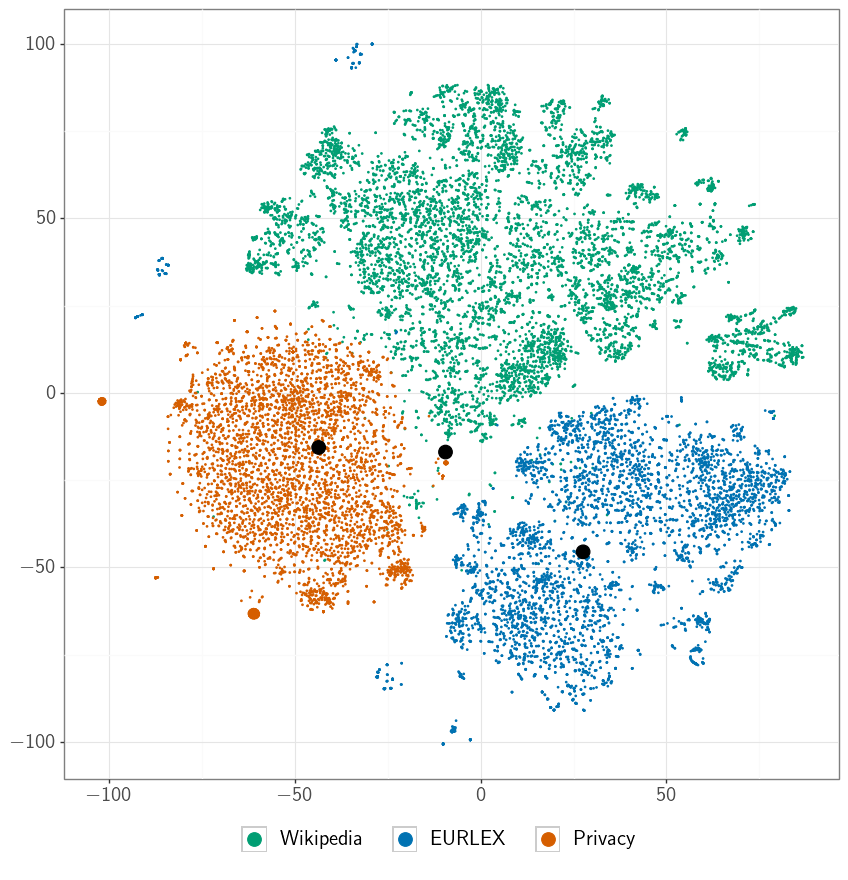

In [274]:
# plot ggplot object
(
    ggplot(aes(x="x", y="y", color="domain"), df.loc[df["method"] == "t-SNE"])
    + geom_point(size=0.1)
    + geom_point(
        aes(x="x", y="y"),
        interesting_df.loc[interesting_df["method"] == "t-SNE"],
        color="black",
        size=5,
    )
    + theme_bw()
    + theme(
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        figure_size=(10, 10),
        text=element_text(size=15),
        legend_text=element_text(margin={"l": 10}),
        legend_position=(0.5, 0.05),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_entry_spacing=20,
        legend_key=element_rect(fill="white"),
        strip_background=element_blank(),
        subplots_adjust={"hspace": 0.15},
    )
    + scale_color_manual(values=["#009e73", "#0072b2", "#d55e00"])
    + guides(color=guide_legend(override_aes={"size": 5}))
).draw();

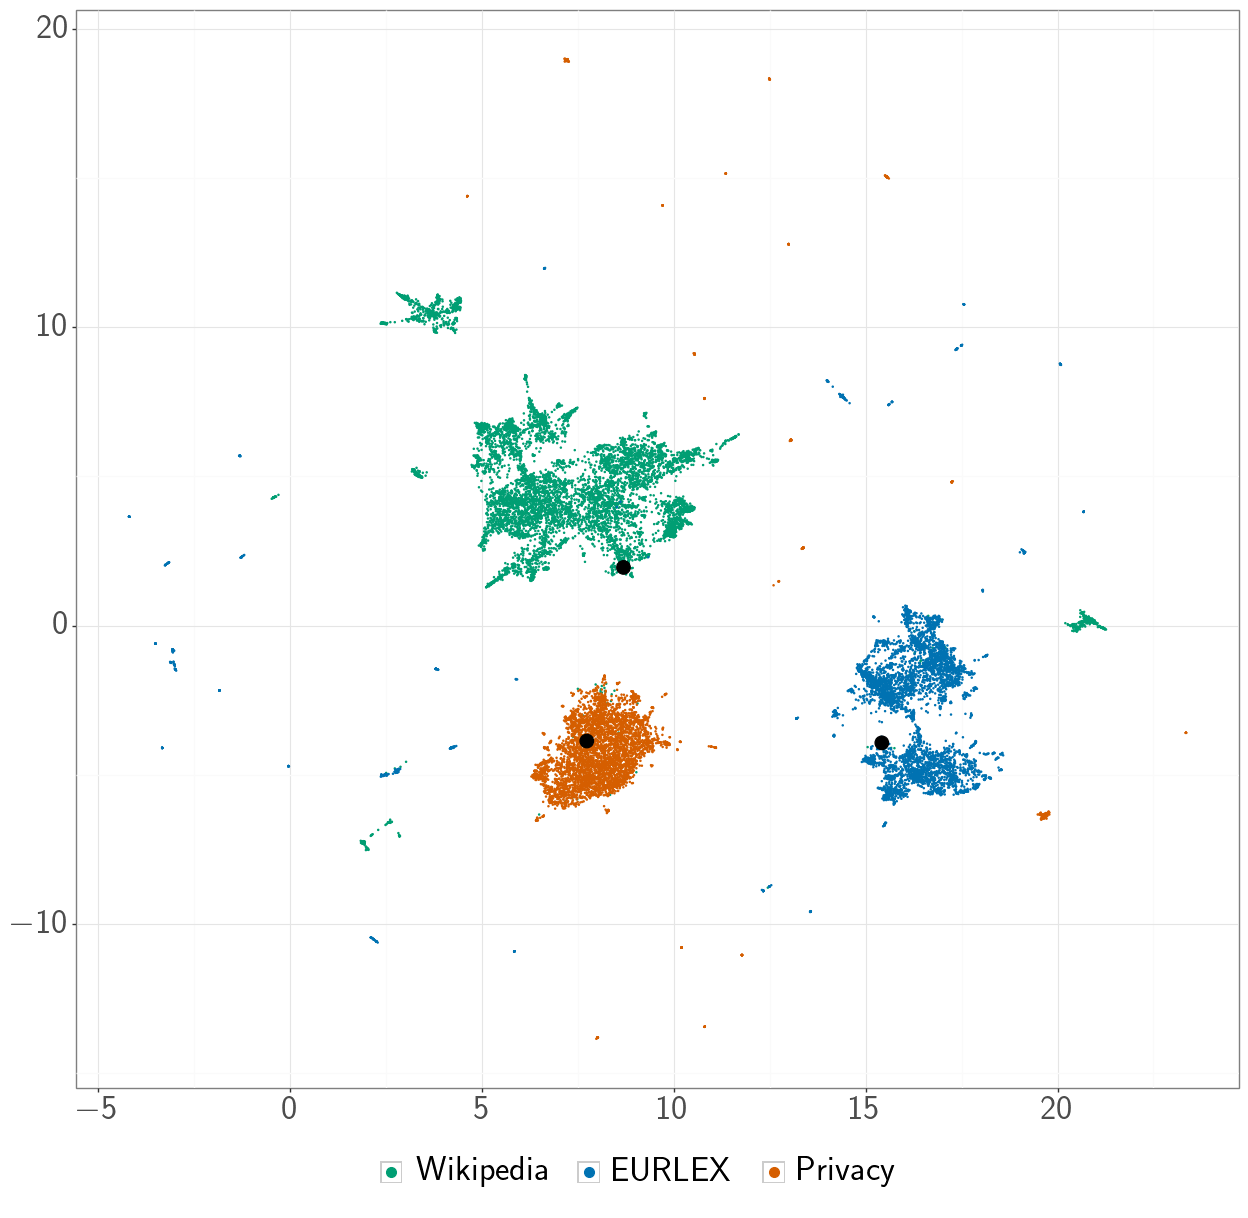

In [276]:
# plot ggplot object
(
    ggplot(aes(x="x", y="y", color="domain"), df.loc[df["method"] == "UMAP"])
    + geom_point(size=0.01)
    + geom_point(
        aes(x="x", y="y"),
        interesting_df.loc[interesting_df["method"] == "UMAP"],
        color="black",
        size=5,
    )
    + theme_bw()
    + theme(
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        figure_size=(15, 14),
        text=element_text(size=25),
        legend_text=element_text(margin={"l": 10}),
        legend_position=(0.5, 0.05),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_entry_spacing=20,
        legend_key=element_rect(fill="white"),
        strip_background=element_blank(),
        subplots_adjust={"hspace": 0.15},
    )
    + scale_color_manual(values=["#009e73", "#0072b2", "#d55e00"])
    + guides(color=guide_legend(override_aes={"size": 3.5}))
).draw();